In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Input, Layer, Subtract, Lambda
from keras.models import Model, Sequential
from keras.preprocessing import image

%matplotlib inline

Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = (15, 6)

In [3]:
from keras import backend as K
from keras.layers import Layer

class WeightsIdentity(Layer):

    def __init__(self, kernel_initializer='glorot_uniform', **kwargs):
        self.kernel_initializer = kernel_initializer
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=input_shape[1:],
                                      initializer=self.kernel_initializer,
                                      trainable=True)
        super().build(input_shape)

    def call(self, x):
        kernel = K.reshape(self.kernel, (1,) + tuple(self.kernel.shape))
        return kernel

    def compute_output_shape(self, input_shape):
        return input_shape
        
def content_loss(_, content_diff):
    return K.mean(K.square(content_diff))

def gram_matrix(X):
    _X = K.squeeze(X, 0)
    features = K.batch_flatten(K.permute_dimensions(_X, (2, 0, 1)))
    return features

def _style_loss(style_diff, img_height, img_width, n_channels):
    size = img_height * img_width
    return K.sum(K.square(style_diff)) / (4 * (n_channels ** 2) * (size ** 2))

def _total_variation_loss(x, img_height, img_width, variation_loss_factor):
    a = K.square(x[:, :img_height - 1, :img_width - 1] - x[:, 1:, :img_width - 1])
    b = K.square(x[:, :img_height - 1, :img_width - 1] - x[:, :img_height - 1, 1:])
    return K.mean(K.pow(a + b, variation_loss_factor))

def _normalize_img(image, mean_rgb_values):
    image = image.astype('float32')
    for i_channel in range(3):
        image[..., i_channel] -= mean_rgb_values[i_channel]
    return image

def _denormalize_img(image, mean_rgb_values):
    image = np.copy(image)
    for i_channel in range(3):
        image[..., i_channel] += mean_rgb_values[i_channel]
    image = np.clip(image, 0, 255).astype('uint8')
    return image

In [4]:
IMG_HEIGHT = 168
IMG_WIDTH = 300
N_CHANNELS = 3
MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4
TOTAL_VARIATION_WEIGHT = 1
TOTAL_VARIATION_LOSS_FACTOR = 1.25

style_loss = lambda _, x: _style_loss(x, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)
total_variation_loss = lambda _, x: _total_variation_loss(x, IMG_HEIGHT, IMG_WIDTH, TOTAL_VARIATION_LOSS_FACTOR)
normalize_img = lambda x: _normalize_img(x, MEAN_RGB_VALUES)
denormalize_img = lambda x: _denormalize_img(x, MEAN_RGB_VALUES)

Imge type (shoud be int8): uint8


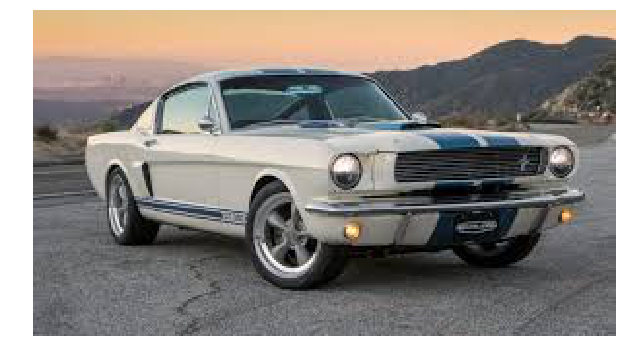

In [ ]:
content_img = np.array(image.load_img('mustang.jpeg', target_size=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
print('Imge type (shoud be int8):', content_img.dtype)
plt.imshow(content_img)
plt.axis('off');

Imge type (shoud be int8): uint8


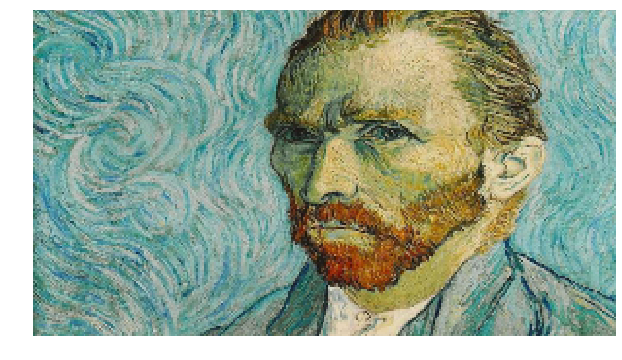

In [ ]:
style_img = np.array(image.load_img('van_gogh_1.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
print('Imge type (shoud be int8):', style_img.dtype)
plt.imshow(style_img)
plt.axis('off');

In [ ]:
def get_model_chunk(model, from_layer, to_layer, include_from=False):
    model_chunk = Sequential()
    from_to_index = [i
                     for i, layer in enumerate(model.layers)
                     if (layer.name.startswith(from_layer) or layer.name.startswith(to_layer))]
    if not include_from:
        from_to_index[0] += 1
        
    for layer in model.layers[from_to_index[0]:from_to_index[1] + 1]:
        model_chunk.add(layer)

    return model_chunk

In [ ]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False)
StyleExtractor1 = get_model_chunk(vgg16, 'input', 'block1_conv1')
StyleExtractor2 = get_model_chunk(vgg16, 'block1_conv1', 'block2_conv1')
StyleExtractor3 = get_model_chunk(vgg16, 'block2_conv1', 'block3_conv1')
StyleExtractor4 = get_model_chunk(vgg16, 'block3_conv1', 'block4_conv1')
ContentExtractor = get_model_chunk(vgg16, 'block4_conv1', 'block5_conv2')

In [ ]:
content_tsr = Input(shape=content_img.shape)
style_tsr = Input(shape=content_img.shape)
# combination_tsr = WeightsIdentity(name="combination_tsr", weights=[normalize_img(content_img)])(content_tsr)
combination_tsr = WeightsIdentity(name="combination_tsr")(content_tsr)

style_tsr_style_1 = StyleExtractor1(style_tsr)
style_tsr_style_2 = StyleExtractor2(style_tsr_style_1)
style_tsr_style_3 = StyleExtractor3(style_tsr_style_2)
style_tsr_style_4 = StyleExtractor4(style_tsr_style_3)

combination_tsr_style_1 = StyleExtractor1(combination_tsr)
combination_tsr_style_2 = StyleExtractor2(combination_tsr_style_1)
combination_tsr_style_3 = StyleExtractor3(combination_tsr_style_2)
combination_tsr_style_4 = StyleExtractor4(combination_tsr_style_3)

content_tsr_content_features = ContentExtractor(
    StyleExtractor4(
        StyleExtractor3(
            StyleExtractor2(
                StyleExtractor1(content_tsr)
            )
        )
    )
)
combination_tsr_content_features = ContentExtractor(combination_tsr_style_4)

style_tsr_style_1_features = Lambda(gram_matrix)(style_tsr_style_1)
style_tsr_style_2_features = Lambda(gram_matrix)(style_tsr_style_2)
style_tsr_style_3_features = Lambda(gram_matrix)(style_tsr_style_3)
style_tsr_style_4_features = Lambda(gram_matrix)(style_tsr_style_4)
combination_tsr_style_1_features = Lambda(gram_matrix)(combination_tsr_style_1)
combination_tsr_style_2_features = Lambda(gram_matrix)(combination_tsr_style_2)
combination_tsr_style_3_features = Lambda(gram_matrix)(combination_tsr_style_3)
combination_tsr_style_4_features = Lambda(gram_matrix)(combination_tsr_style_4)

content_features_diff = Subtract(name='content_features_diff')(
    [content_tsr_content_features, combination_tsr_content_features])
style_features_diff_1 = Subtract(name='style_features_diff_1')(
    [style_tsr_style_1_features, combination_tsr_style_1_features]
)
style_features_diff_2 = Subtract(name='style_features_diff_2')(
    [style_tsr_style_2_features, combination_tsr_style_2_features]
)
style_features_diff_3 = Subtract(name='style_features_diff_3')(
    [style_tsr_style_3_features, combination_tsr_style_3_features]
)
style_features_diff_4 = Subtract(name='style_features_diff_4')(
    [style_tsr_style_4_features, combination_tsr_style_4_features]
)

In [ ]:
model = Model(
    inputs=[content_tsr, style_tsr],
    outputs=[combination_tsr,
             content_features_diff,
             style_features_diff_1,
             style_features_diff_2,
             style_features_diff_3,
             style_features_diff_4]
)
for layer in model.layers:
    if layer.name != 'combination_tsr':
        layer.trainable = False

In [ ]:
from keras.optimizers import Adam

In [ ]:
losses = {
    'combination_tsr': total_variation_loss,
    'content_features_diff': content_loss,
    'style_features_diff_1': style_loss,
    'style_features_diff_2': style_loss,
    'style_features_diff_3': style_loss,
    'style_features_diff_4': style_loss
}
loss_weights={
    'combination_tsr': TOTAL_VARIATION_WEIGHT,
    'content_features_diff': CONTENT_WEIGHT,
    'style_features_diff_1': STYLE_WEIGHT / 4,
    'style_features_diff_2': STYLE_WEIGHT / 4,
    'style_features_diff_3': STYLE_WEIGHT / 4,
    'style_features_diff_4': STYLE_WEIGHT / 4
}

model.compile(Adam(lr=0.001), loss=losses, loss_weights=loss_weights)

In [ ]:
from keras.callbacks import Callback
 
class ShowCombination(Callback):
    def __init__(self, content_img, style_img):
        self.content_img = content_img
        self.style_img = style_img
        
    def on_epoch_end(self, epoch, logs={}):
        content_batch = self.content_img[None, ...]
        style_batch = self.style_img[None, ...]
        combination_img = np.squeeze(self.model.predict_on_batch([content_batch, style_batch])[0])
        combination_img = denormalize_img(combination_img)
        plt.imshow(np.hstack((self.content_img, combination_img, self.style_img)))
        plt.axis('off')
        plt.title('Content' + ' ' * 50 + 'Combination' + ' ' * 50 + 'Style')
        plt.show()

In [ ]:
def input_generator(content_img, style_img, batch_size):
    content_img = normalize_img(content_img)
    style_img = normalize_img(style_img)
    content_batch = np.repeat(content_img[None, ...], batch_size, 0)
    style_batch = np.repeat(style_img[None, ...], batch_size, 0)
    while True:
        yield [content_batch, style_batch], [content_batch] * 6

batch_size = 1
epochs = 100
samples_per_epoch = 20000
model.fit_generator(
    input_generator(content_img, style_img, batch_size),
    epochs=epochs,
    steps_per_epoch=samples_per_epoch,
    verbose=1,
    callbacks=[ShowCombination(content_img, style_img)]
)

Epoch 1/100
15139/20000 [=====================>........] - ETA: 1:51 - loss: 22.1398 - combination_tsr_loss: 1.8119 - content_features_diff_loss: 824.6431 - style_features_diff_1_loss: 0.0593 - style_features_diff_2_loss: 1.4347 - style_features_diff_3_loss: 1.8969 - style_features_diff_4_loss: 0.4441

In [ ]:
content_batch = content_img[None, ...]
style_batch = style_img[None, ...]
combination_img = np.squeeze(model.predict_on_batch([content_batch, style_batch])[0])
combination_img = denormalize_img(combination_img)
plt.imshow(combination_img)
plt.axis('off')
plt.title('Combination')
plt.show()